In [153]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [154]:
df = pd.read_csv('uber.csv')

In [155]:
df.head()


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [156]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [157]:
df.columns


Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [158]:
df = df.drop(['Unnamed: 0', 'key'], axis= 1)


In [159]:
df.shape


(200000, 7)

In [160]:
df.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [161]:
df.isnull().sum()


,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [162]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce')


In [163]:
df.dtypes


,0
fare_amount,float64
pickup_datetime,"datetime64[ns, UTC]"
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64


In [164]:
df= df.assign(hour = df.pickup_datetime.dt.hour,
             day= df.pickup_datetime.dt.day,
             month = df.pickup_datetime.dt.month,
             year = df.pickup_datetime.dt.year,
             dayofweek = df.pickup_datetime.dt.dayofweek)



In [165]:
pip install haversine


In [166]:
df = df[
    (df['pickup_longitude'].between(-74.3, -73.7)) &
    (df['pickup_latitude'].between(40.5, 40.9)) &
    (df['dropoff_longitude'].between(-74.3, -73.7)) &
    (df['dropoff_latitude'].between(40.5, 40.9)) &
    (df['fare_amount'].between(0.1, 500)) &
    (df['passenger_count'].between(1, 6))
]

print(f"Data cleaned. Remaining rows: {len(df)}")

Data cleaned. Remaining rows: 194783


In [167]:
from haversine import haversine, Unit
def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(pickup, dropoff, unit=Unit.KILOMETERS)

df['distance_km'] = df.apply(calculate_distance, axis=1)

In [168]:
df.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,distance_km
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3,1.683325
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4,2.457593
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0,5.036384
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4,1.661686
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,3,4.475456


In [169]:
df = df.drop('pickup_datetime',axis=1)

In [170]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 194783 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        194783 non-null  float64
 1   pickup_longitude   194783 non-null  float64
 2   pickup_latitude    194783 non-null  float64
 3   dropoff_longitude  194783 non-null  float64
 4   dropoff_latitude   194783 non-null  float64
 5   passenger_count    194783 non-null  int64  
 6   hour               194783 non-null  int32  
 7   day                194783 non-null  int32  
 8   month              194783 non-null  int32  
 9   year               194783 non-null  int32  
 10  dayofweek          194783 non-null  int32  
 11  distance_km        194783 non-null  float64
dtypes: float64(6), int32(5), int64(1)
memory usage: 15.6 MB


In [171]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
fare_amount,194783.0,11.295347,9.512100,0.110000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,194783.0,-73.975530,0.034511,-74.299012,-73.992278,-73.982120,-73.968415,-73.702735
pickup_latitude,194783.0,40.750774,0.026915,40.508697,40.736462,40.753288,40.767507,40.897572
dropoff_longitude,194783.0,-73.974620,0.034100,-74.299833,-73.991602,-73.980565,-73.965487,-73.700650
dropoff_latitude,194783.0,40.751006,0.030603,40.510800,40.735335,40.753725,40.768293,40.899914
passenger_count,194783.0,1.689891,1.305797,1.000000,1.000000,1.000000,2.000000,6.000000
hour,194783.0,13.491064,6.515133,0.000000,9.000000,14.000000,19.000000,23.000000
day,194783.0,15.702525,8.688330,1.000000,8.000000,16.000000,23.000000,31.000000
month,194783.0,6.285359,3.440462,1.000000,3.000000,6.000000,9.000000,12.000000
year,194783.0,2011.741435,1.861923,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000


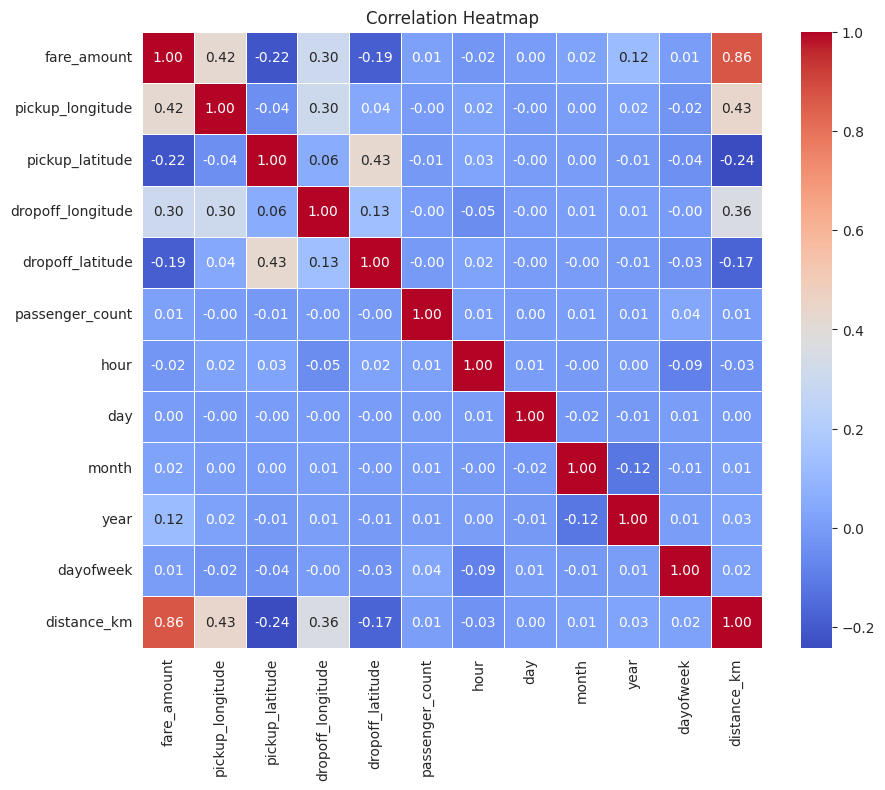

In [172]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


<Axes: title={'center': 'Cab trips count during week days'}, xlabel='hour', ylabel='count'>

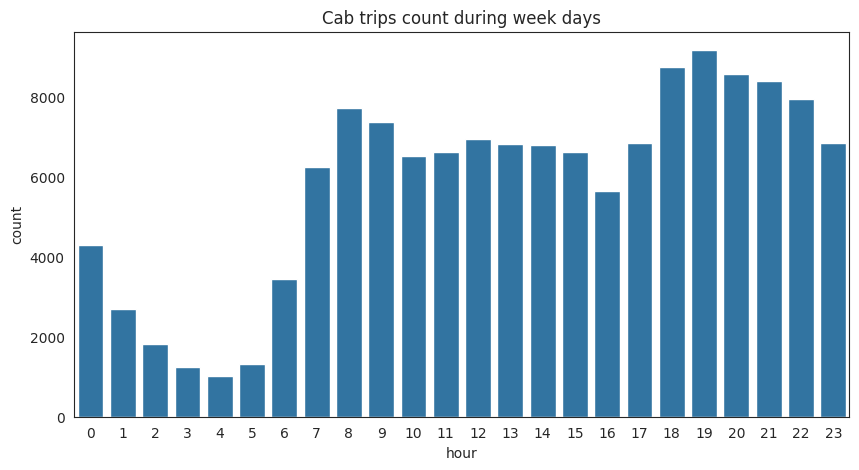

In [173]:
plt.figure(figsize=(10,5))
plt.title('Cab trips count during week days')
#plot the countplot for weekdays
sns.countplot(x='hour', data=df.loc[(df.dayofweek >= 0) & (df.dayofweek <=4)])

<Axes: title={'center': 'Cab trips count during week ends'}, xlabel='hour', ylabel='count'>

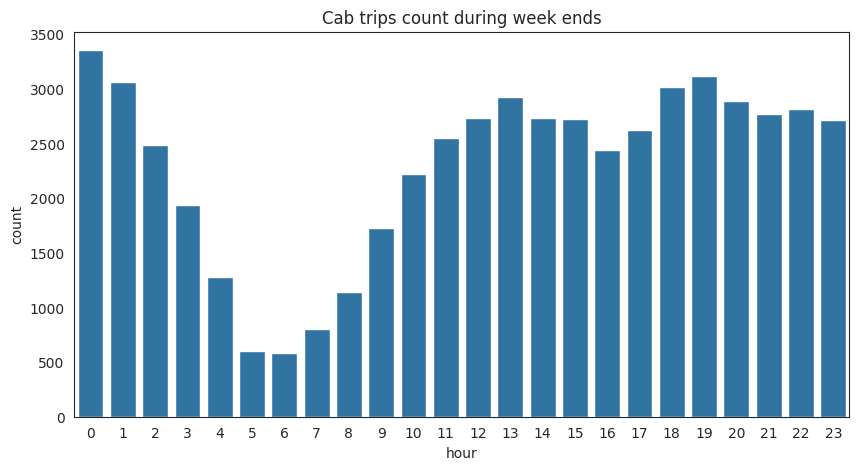

In [174]:
plt.figure(figsize=(10,5))
plt.title('Cab trips count during week ends')

#plot the countplot for weekends
sns.countplot(x='hour', data=df.loc[(df.dayofweek >= 5) & (df.dayofweek <=6)])

Text(0, 0.5, 'Latitude')

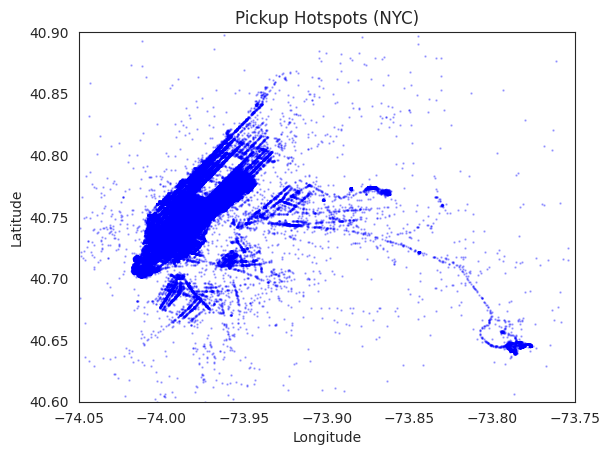

In [175]:
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], s=0.5, alpha=0.3, c='blue')
plt.xlim(-74.05, -73.75)
plt.ylim(40.6, 40.9)
plt.title('Pickup Hotspots (NYC)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0.5, 1.0, 'Distance vs Fare Correlation')

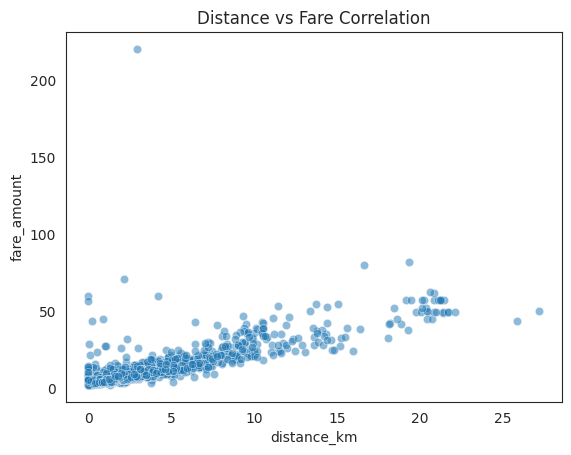

In [176]:
sns.scatterplot(x='distance_km', y='fare_amount', data=df.sample(2000), alpha=0.5)
plt.title('Distance vs Fare Correlation')

In [177]:
df_x = df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','hour','day','month','year','dayofweek','distance_km']]
df_y = df['fare_amount']

In [178]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=1)


In [179]:
reg = LinearRegression()

reg.fit(x_train, y_train)

LinearRegression()

In [180]:
y_pred_lin = reg.predict(x_test)
print(y_pred_lin)

[ 5.6290868   7.72365758 11.82024993 ... 18.30669838  6.36034312
 10.89239364]


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train,y_train)

In [ ]:
y_pred_rf = rf.predict(x_test)
print(y_pred_rf)

In [ ]:
def get_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    }

lin_metrics = get_metrics(y_test, y_pred_lin, "Linear Regression")

rf_metrics = get_metrics(y_test, y_pred_rf, "Random Forest")

comparison_df = pd.DataFrame([lin_metrics, rf_metrics])

comparison_df.set_index('Model', inplace=True)

print(comparison_df)

print("\nConclusion: Random Forest performed better.")